In [43]:
import numpy as np
import pandas as pd

In [44]:
from powerNetworkSolver import PowerNetworkSolver
from powerNetwork import networkTransform, getGenerators, getBuses, getLines,getNumBuses, getNumLines
from powerNetwork import getUndGraph, kron_reduction, edge_removing
from disturbancesGnr import normaldisturbances
from violationChecking import globalcheck
import seaborn as sns
sns.set_theme()
#importing the function for multi-edge removal
from powerNetwork import multi_edge_removing


In [45]:
import matplotlib.pyplot as plt

In [46]:

import numpy as np
import copy
from numpy.linalg import inv
import networkx as nx
from numpy.random import multivariate_normal
from disturbancesGnr import normaldisturbances,correlated_disturbances
from scipy.integrate import odeint
from violationChecking import globalcheck
import math
from functools import reduce

In [47]:
# 1. Test Case 39, complete network

In [48]:
from pypower.api import case39

In [49]:
network39, subnetwork39 = networkTransform(case39())
df_lines39 = getLines(subnetwork39)
df_buses39 = getBuses(subnetwork39)

In [50]:
n39, ngnr39, unG39 = getUndGraph(df_buses39,df_lines39, network39)
A39, redL39, redA39  = kron_reduction(n39, ngnr39, unG39)
node_list =  np.arange(ngnr39)+1

#the previous adjacent matrix
# redA39 = np.array([[0,2.484, 2.858, 2.372, 1.031, 0.222,2.13,13.057,3.676,7.834],
#               [2.484,0,10.494,1.781,0.774,0.166,1.599,1.473,0.903,5.885],
#               [2.858,10.494,0,2.522,1.096,0.236,2.264,1.729,1.144,4.772],
#               [2.372,1.781,2.522,0,17.136,0.535,5.14,1.699,1.755,1.367],
#               [1.031,0.774, 1.096,17.136,0 ,0.232, 2.235, 0.739, 0.763, 0.594],
#               [0.222,0.166,0.236,0.535,0.232,0,1.574, 0.159, 0.164, 0.128],
#               [2.13,1.599,2.264, 5.14, 2.235, 1.574, 0, 1.526, 1.576, 1.227],
#               [13.057,1.473,1.729, 1.699,0.739, 0.159, 1.526, 0, 4.283, 4.159],
#               [3.676, 0.903, 1.144, 1.755, 0.763, 0.164, 1.576, 4.283, 0, 1.37],
#               [7.834, 5.885, 4.772, 1.367, 0.594, 0.128, 1.227, 4.159, 1.37 ,0]])

# redA39 = np.ones((ngnr39,ngnr39))
# np.fill_diagonal(redA39, 0)


In [51]:
print(redL39)

[[ 32.19339596  -2.24077412  -2.53804929  -1.83375379  -0.84971196
   -1.97837115  -1.10734538 -11.4337488   -3.17111386  -7.0405276 ]
 [ -2.24077412  24.34176732  -9.78362621  -1.46126519  -0.6771108
   -1.57650656  -0.8824114   -1.33259746  -0.79623472  -5.59124086]
 [ -2.53804929  -9.78362621  25.7907586   -2.04017565  -0.94536227
   -2.20107229  -1.23199695  -1.53776482  -0.98920455  -4.52350657]
 [ -1.83375379  -1.46126519  -2.04017565  32.10610533 -15.62000109
   -4.7048095   -2.63340327  -1.32379253  -1.36949665  -1.11940767]
 [ -0.84971196  -0.6771108   -0.94536227 -15.62000109  23.25921633
   -2.18008159  -1.22024792  -0.61340969  -0.63458774  -0.51870327]
 [ -1.97837115  -1.57650656  -2.20107229  -4.7048095   -2.18008159
   30.63199579 -13.87777293  -1.42819225  -1.47750078  -1.20768875]
 [ -1.10734538  -0.8824114   -1.23199695  -2.63340327  -1.22024792
  -13.87777293  23.25554375  -0.79939605  -0.82699531  -0.67597456]
 [-11.4337488   -1.33259746  -1.53776482  -1.32379253  -

In [52]:
K = 1
M = np.array([0.2228, 0.1607, 0.1899, 0.1517, 0.1379, 0.1846, 0.1401, 0.1289, 0.183, 2.6526])
D = np.array([0.0332,0.076,0.0862,0.0838,0.0674,0.0862,0.0743,0.0716,0.1101,0.1333])
# Ome = np.zeros(n)
pi = math.pi
t =  2
nn = 100
dt = np.linspace(0, t, nn+1)

sigma = 0.01
theta0 = np.zeros(ngnr39)
omega0 = np.zeros(ngnr39)
OMEGA = np.zeros(ngnr39)
model39 = PowerNetworkSolver(theta0,omega0,redA39,redL39, ngnr39, D,M,K,OMEGA)

In [53]:
from numpy.random import seed

In [60]:
#generate numerical tracks
# seed(100)
# disturbances = correlated_disturbances(delta=1, alpha=1.5, tau=1.5, n=ngnr39, L=redL39, k=1)
disturbancesc = normaldisturbances(n=ngnr39,k=1,sigma=sigma)
sol0 = np.pad(disturbances[0], (ngnr39,0), 'constant', constant_values=(0,0))
single_sol = model39.solkuramoto(sol0,dt)
sol_domega = model39.getDotOmega(single_sol[:,:ngnr39],single_sol[:,ngnr39:],nn)

Text(0.5, 1.0, 'Phase angles')

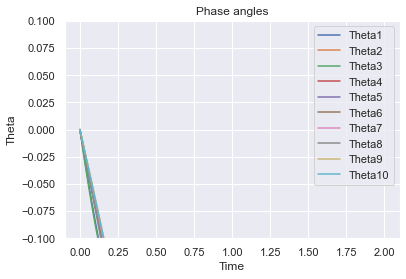

In [61]:
for i in range(ngnr39):
    theta = single_sol[:,i]
    plt.plot(dt, theta, "-", label="Theta"+ str(i+1))

plt.xlabel("Time")
plt.ylabel("Theta")
plt.ylim(-0.1, 0.1)
plt.legend();
plt.title('Phase angles')

Text(0.5, 1.0, 'Natural rotation frequencies')

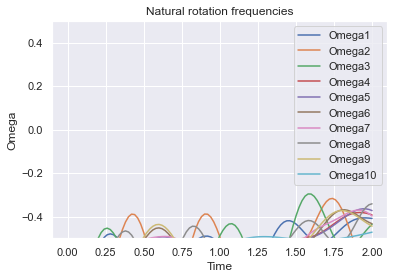

In [62]:
for i in range(ngnr39):
    omega = single_sol[:,ngnr39+i]
    plt.plot(dt, omega, "-", label="Omega"+ str(i+1))


plt.xlabel("Time")

plt.ylabel("Omega")
plt.ylim(-0.5, 0.5)
plt.legend();
plt.title('Natural rotation frequencies')

Text(0.5, 1.0, 'Change Rates of Natural rotation frequencies')

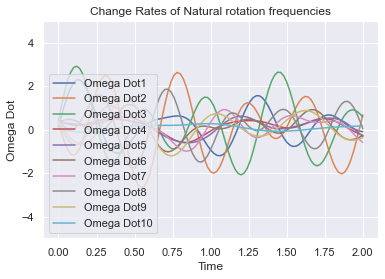

In [63]:
for i in range(ngnr39):
    domega = sol_domega[:,i]
    plt.plot(dt, domega, "-", label="Omega Dot"+ str(i+1))

plt.xlabel("Time")
plt.ylabel("Omega Dot")
plt.ylim(-5, 5)
plt.legend();
plt.title('Change Rates of Natural rotation frequencies')

In [ ]:
# simulation to calculate failure rates
check_times = 100
KK =3000#repetition times
thres = np.array([0.2,2])#thres1 is for omega, thres2 is for omega_dot
rates39 = model39.Simulation(KK, check_times, sigma, thres, t, nn, normaldisturbances)

In [ ]:
print(rates39['totaltime'])

In [ ]:
df39 = pd.DataFrame({'Node': node_list,'RoCoF': rates39['vcheck_omega'] , 'AFV': rates39['vcheck_theta'] ,'AV': rates39['vcheck_any']})
print(df39.to_latex(index=False))
